# Imports

In [1]:
from primed_data_processing.cellbuilder import CellBuilder
from primed_data_processing.gamry_eis import EisSweep
from primed_data_processing.arbin_cycler import ArbinCell

import os
import matplotlib.pyplot as plt
import numpy as np

## EIS

### FileIO and Helper Functions

In [2]:
def load_eis(prepath, channel_numbers, file_prefix, file_suffix):
    leaf_prepath = prepath
    eis_sweeps = []
    for channel_number in channel_numbers:
        eis_sweep = EisSweep(f'channel{channel_number}', 0.5)
        eis_sweep.read_DTA_file(leaf_prepath + file_prefix + f'{channel_number}' + file_suffix)
        eis_sweeps.append(eis_sweep)
    return eis_sweeps

In [3]:
def plot_eis(eis_sweeps, xlimit=[], ylimit=[], exclude=[], freq_labels=False):

    for sweep in eis_sweeps:
        if sweep.name not in exclude:
            plt.plot(sweep['Zreal (ohm)'], -1*np.array(sweep['Zimag (ohm)']), label=sweep.name, marker='o')

    if xlimit:
        plt.xlim(xlimit)
    if ylimit:
        plt.ylim(ylimit)
    plt.xlabel('Real Impedance (Ohm)')
    plt.ylabel('Imaginary Impedance (Ohm)')
    plt.legend()
    plt.grid()

In [4]:
# load gen1 pack1
leaf_prepath = 'C:/Users/seanb/OneDrive/Documents/PRIMED/Battery Data/Leaf Gamry Data/'
channel_numbers = (5,6,7,8)
gen1_pack1_eis = load_eis(leaf_prepath, channel_numbers, 'init_gen1_pack1_Chan00', '_Cycle001_Step013.DTA')

# load gen1 pack2
channel_numbers = (1,2,3,4) 
gen1_pack2_eis = load_eis(leaf_prepath, channel_numbers, 'init_gen1_pack2_Chan00', '_Cycle001_Step013.DTA')

# load gen3 
channel_numbers = (1,2,3,4,5,6)
gen3_eis = load_eis(leaf_prepath, channel_numbers, 'init_gen3_pack1_56Ah_Chan00', '_Cycle001_Step013.DTA')

In [7]:
def convert_eis_to_csv(folder_path, eis_sweeps):
    for channel_number, sweep in enumerate(eis_sweeps):
        sweep.get_data_as_dataframe().to_csv(
            folder_path +f'init_gen1_pack2_Chan00{channel_number}_Cycle001_Step013.csv',
            index=False
            )

### Plotting

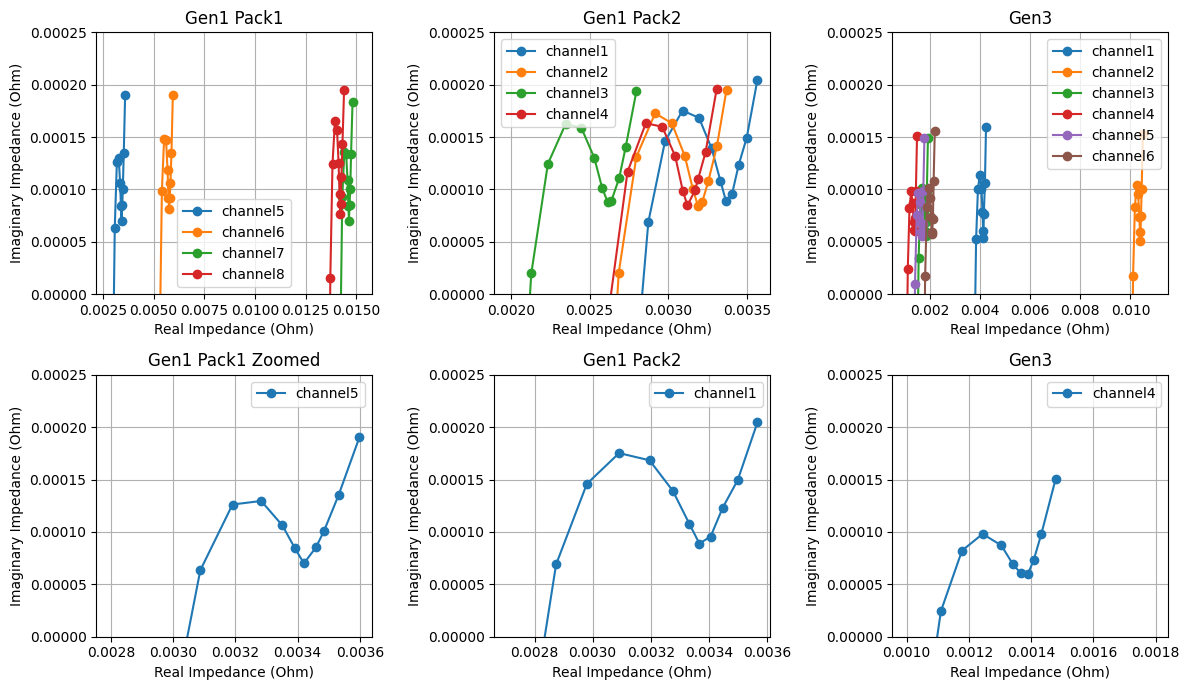

In [5]:
%matplotlib inline
plt.figure(figsize=(12,7))
plt.subplot(231)
plot_eis(gen1_pack1_eis, ylimit=[0,0.00025])
plt.title('Gen1 Pack1')
plt.subplot(232)
plot_eis(gen1_pack2_eis, ylimit=[0,0.00025])
plt.title('Gen1 Pack2')
plt.subplot(233)
plot_eis(gen3_eis, ylimit=[0,0.00025])
plt.title('Gen3')
plt.subplot(234)
plot_eis(gen1_pack1_eis[0:1], ylimit=[0,0.00025])
plt.title('Gen1 Pack1 Zoomed')
plt.subplot(235)
plot_eis(gen1_pack2_eis[0:1], ylimit=[0,0.00025])
plt.title('Gen1 Pack2')
plt.subplot(236)
plot_eis(gen3_eis[3:4], ylimit=[0,0.00025])
plt.title('Gen3')
plt.tight_layout()

## Cycling Data

### FileIO and Helper Functions

In [6]:
# Data loading
def load_leaf_data(folder_path, steps, cell_builder) -> dict[int: ArbinCell]:
    cells = {}
    directory = os.fsencode(folder_path)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        cell_list = cell_builder.read_leaf_characterization_excel_data(folder_path+filename, steps=steps)
        for cell in cell_list:
            cells[cell.channel_number] = cell
    
    return cells

def load_leaf_data_by_step(folder_path, cell_builder, unique_identifier, steps) -> dict[int: ArbinCell]:
    main_directory = os.fsencode(folder_path)
    processed_cells = {}
    for directory in os.listdir(main_directory):
        directory = os.fsdecode(directory)
        if unique_identifier in directory:
            cells = load_leaf_data(folder_path+directory+'/', {'characterization': steps}, cell_builder)
            processed_cells.update(cells)
    return processed_cells

In [7]:
# Downloading data
arbin_data_prepath = 'C:/Users/seanb/OneDrive/Documents/PRIMED/Battery Data/Leaf Arbin Data/'
cell_builder = CellBuilder()
steps = [num for num in range(1,26)]

# load gen1 pack1
gen1_pack1_cells = load_leaf_data_by_step(arbin_data_prepath, cell_builder, 'pack1_5_', steps)

# load gen1 pack2
gen1_pack2_cells = load_leaf_data_by_step(arbin_data_prepath, cell_builder, 'pack2', steps)

# load gen3
gen3_cells = load_leaf_data_by_step(arbin_data_prepath, cell_builder, '56Ah', steps)

Channel_5_1
Channel_6_1
Channel_7_1
Global_Info
Channel_8_1
Global_Info
Channel_1_1
Channel_2_1
Channel_3_1
Global_Info
Channel_4_1
Global_Info
Channel_1_1
Channel_2_1
Channel_3_1
Global_Info
Channel_4_1
Channel_5_1
Channel_6_1
Global_Info


In [8]:
# plotting helper functions
def plot_dcir_soh(ax, cells_dict, nom_cap):
    sohs = []
    dcir = []
    for channel, cell in cells_dict.items():
        for cycle in cell:
            sohs.append(cycle.get_step(9)[0]['Discharge_Capacity(Ah)'][-1]/nom_cap)
            dcir.append(cycle.get_step(15)[0]['Internal Resistance(Ohm)'])
    ax.scatter(cells_dict.keys(), sohs, label='SOH')
    axy = ax.twinx()
    axy.scatter(cells_dict.keys(), dcir, label='DCIR',color='orange')
    ax.set_xlabel('Channel Number')
    ax.set_ylabel('SOH')
    axy.set_ylabel('DCIR')
    
def plot_cc_cv_step(ax, cells_dict, feature: str):
    cv_time = []
    step_5_time = []
    step_5_feature = []
    step_6_feature = []
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for channel, cell in cells_dict.items():
        for cycle in cell:
            step_5 = cycle.get_step(5)[0]
            step_6 = cycle.get_step(6)[0]
            cv_time.append(np.array(step_6["Step_Time(s)"]) + step_5["Step_Time(s)"][-1])
            step_5_time.append(step_5["Step_Time(s)"])
            step_5_feature.append(step_5[feature])
            step_6_feature.append(step_6[feature])
   
    for idx, step_time in enumerate(step_5_time):
        ax.plot(step_5_time[idx], step_5_feature[idx], color=colors[idx], label=f'channel {list(cells_dict.keys())[idx]}')
        ax.plot(cv_time[idx], step_6_feature[idx], color=colors[idx])
    ax.set_ylabel(feature)
    ax.set_xlabel('Time (s)')
    ax.legend()

def subplot_cc_cv(feature):
    fig, ax = plt.subplots(1,3, figsize=(12,5))
    plot_cc_cv_step(ax[0], gen1_pack1_cells, feature)
    ax[0].set_title('Gen1 Pack1')
    plot_cc_cv_step(ax[1], gen1_pack2_cells, feature)
    ax[1].set_title('Gen1 Pack2')
    plot_cc_cv_step(ax[2], gen3_cells, feature)
    ax[2].set_title('Gen3')

def plot_ocv(ax, cells_dict, feature, nom_cap, step_number: int, x_units: str):
    for channel, cell in cells_dict.items():
        for cycle in cell:
            for step in cycle:
                if step.step_index == step_number:
                    soc = np.array(step[feature])/nom_cap
                    time_in_mins = np.array(step['Step_Time(s)'])/60
                    if x_units == 'time':
                        ax.plot(time_in_mins, step['Voltage(V)'], label=f'Channel: {channel}')
                    elif x_units == 'soc':
                        ax.plot(soc, step['Voltage(V)'], label=f'Channel: {channel}')
    if x_units == 'time':
        ax.set_xlabel('Time (min)')
    elif x_units == 'soc':
        ax.set_xlabel('SOC')
    ax.set_ylabel('Voltage (V)')
    ax.legend();

def subplot_ocv(feature, step_number, x_units='time'):
    fig, ax = plt.subplots(1,3, figsize=(12,5))
    plot_ocv(ax[0], gen1_pack1_cells, feature, 33, step_number, x_units)
    ax[0].set_title('Gen1 Pack1')
    plot_ocv(ax[1], gen1_pack2_cells, feature, 33, step_number, x_units)
    ax[1].set_title('Gen1 Pack2')
    plot_ocv(ax[2], gen3_cells, feature, 56, step_number, x_units)
    ax[2].set_title('Gen3')

### Plotting

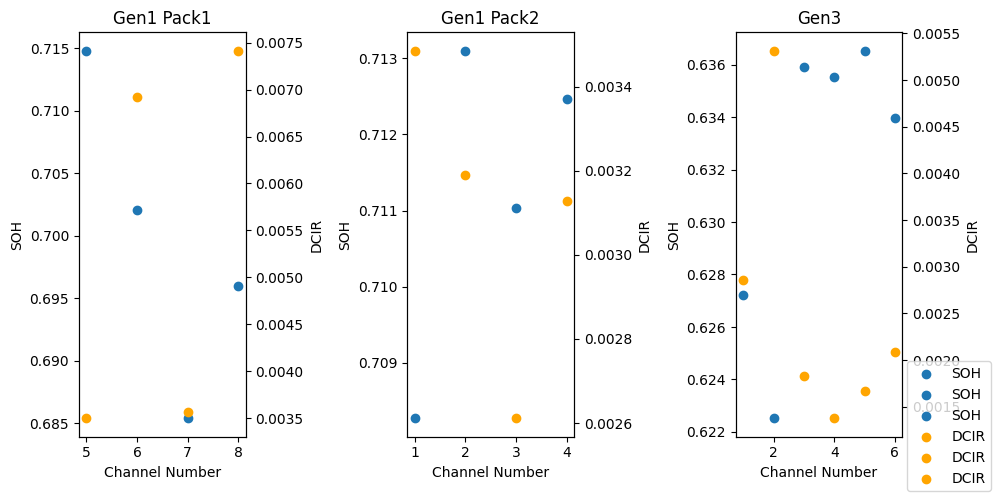

In [9]:
fig, ax = plt.subplots(1,3, figsize=(10,5))
axy = plot_dcir_soh(ax[0], gen1_pack1_cells, 33)
ax[0].set_title('Gen1 Pack1')
axy = plot_dcir_soh(ax[1], gen1_pack2_cells, 33)
ax[1].set_title('Gen1 Pack2')
axy = plot_dcir_soh(ax[2], gen3_cells, 56)
ax[2].set_title('Gen3')
fig.legend(loc='lower right')
fig.tight_layout()

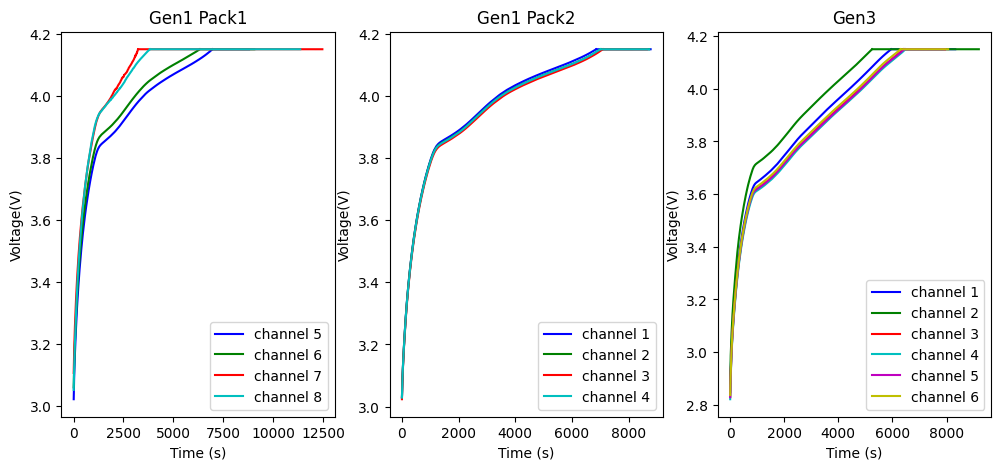

In [10]:
subplot_cc_cv('Voltage(V)')

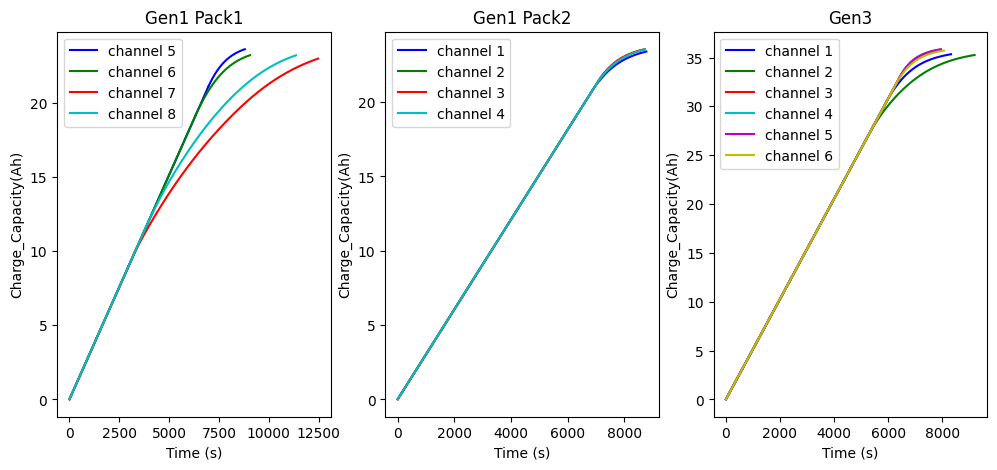

In [11]:
subplot_cc_cv('Charge_Capacity(Ah)')

## OCV

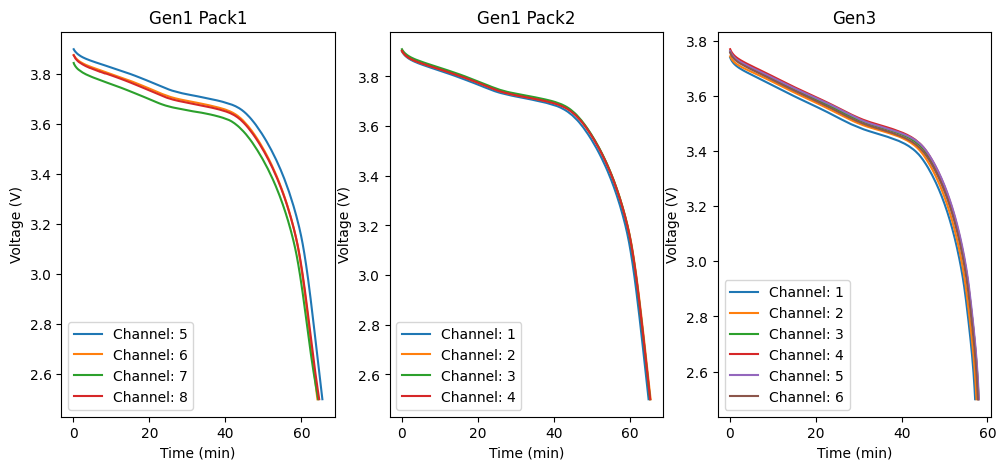

In [12]:
subplot_ocv('Discharge_Capacity(Ah)',18, x_units='time')

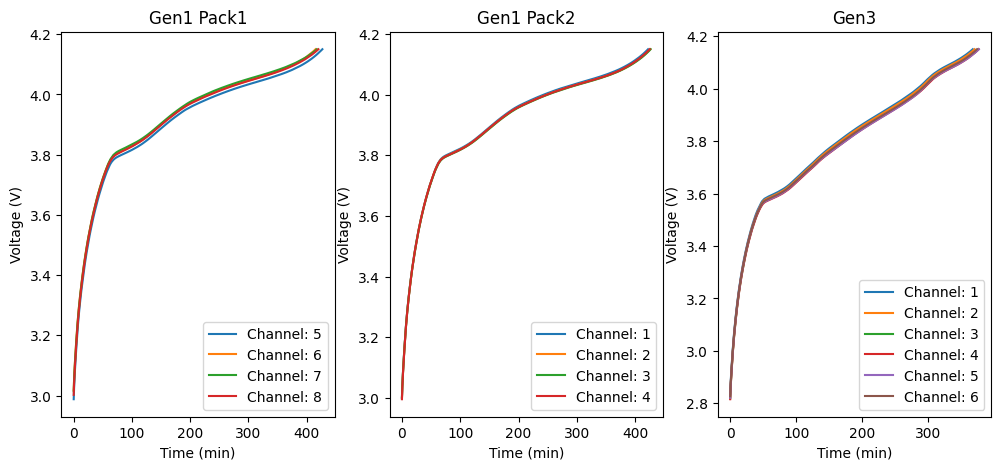

In [13]:
subplot_ocv('Charge_Capacity(Ah)',21, x_units='time')